# Speed Anomalies - Project 6

## Project Description
### The project tries to identify anomalies in the speeds observed by the sensors over real time traffic in Minnesota

## Dataset source
### https://www.kaggle.com/boltzmannbrain/nab

#### import required libraries

In [1]:
from pandas import DataFrame, read_csv
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt

#### Load required data

In [2]:
trafficSpeedsData=pd.read_csv('/Users/sdamaraju/PycharmProjects/IntroToDS-731/Anomaly Detection - Project 6/data/processed/speed_7578.csv');

### Minimal or No Data processing as there are just 2 columns and no null values.

## Basic Data Exploration
#### Plotting speeds over time.

In [3]:
trafficSpeedsData.head()

,timestamp,value
0,2015-09-08 11:39:00,73
1,2015-09-08 11:44:00,62
2,2015-09-08 11:59:00,66
3,2015-09-08 12:19:00,69
4,2015-09-08 12:24:00,65


Text(0.5, 1.0, 'Speeds in Minnesota')

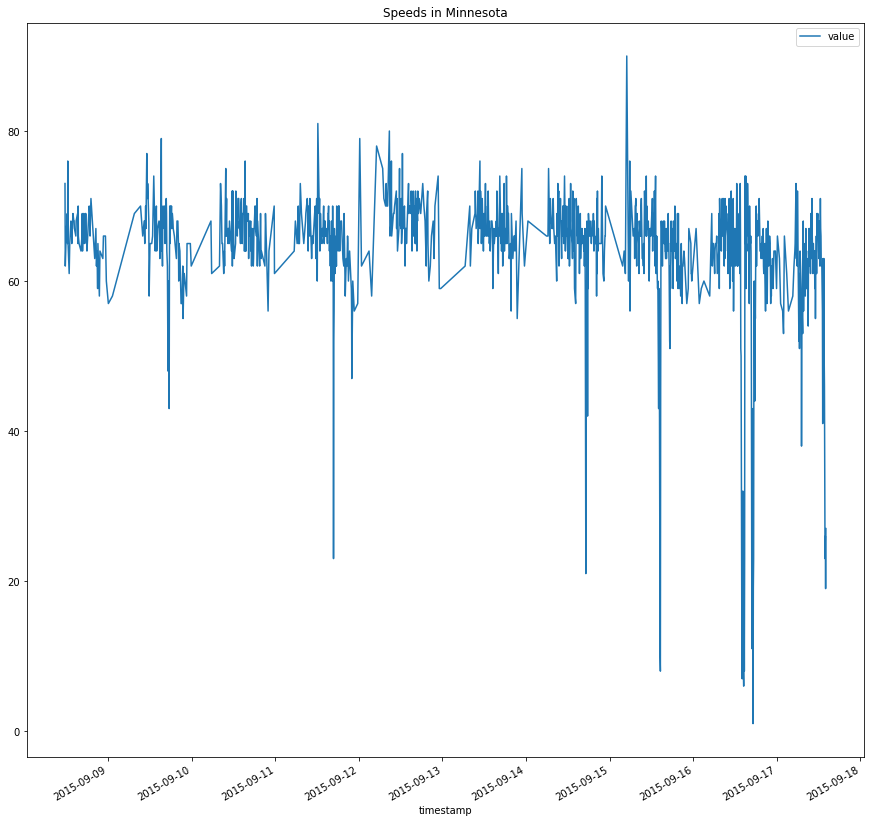

In [4]:
trafficSpeedsData['timestamp'] = pd.to_datetime(trafficSpeedsData['timestamp'])
trafficSpeedsData.plot(x='timestamp', y='value',figsize=(15,15))
plt.title('Speeds in Minnesota')

### The above graph clearly tells us that there are drops in speeds from 15th to 18th of September 2015,
### Lets calculate the mean of speeds per day.

## Feature Engineering

#### In ordeer to evaluate data further we need to feature engineer the timestamp column to get the year, month and date fields out.

In [5]:
trafficSpeedsData['Hour'] = trafficSpeedsData['timestamp'].dt.hour
trafficSpeedsData['Day'] = trafficSpeedsData['timestamp'].dt.day
trafficSpeedsData

,timestamp,value,Hour,Day
0,2015-09-08 11:39:00,73,11,8
1,2015-09-08 11:44:00,62,11,8
2,2015-09-08 11:59:00,66,11,8
3,2015-09-08 12:19:00,69,12,8
4,2015-09-08 12:24:00,65,12,8
...,...,...,...,...
1122,2015-09-17 13:45:00,33,13,17
1123,2015-09-17 13:50:00,23,13,17
1124,2015-09-17 13:55:00,26,13,17
1125,2015-09-17 14:00:00,19,14,17


In [6]:
trafficAverageSpeedByDate = trafficSpeedsData.groupby(['Day'])['value'].mean().reset_index()
trafficAverageSpeedByDate

,Day,value
0,8,66.133333
1,9,65.298851
2,10,66.724490
3,11,65.262712
4,12,68.418605
5,13,67.034483
6,14,65.500000
7,15,63.329268
8,16,59.336898
9,17,59.613208


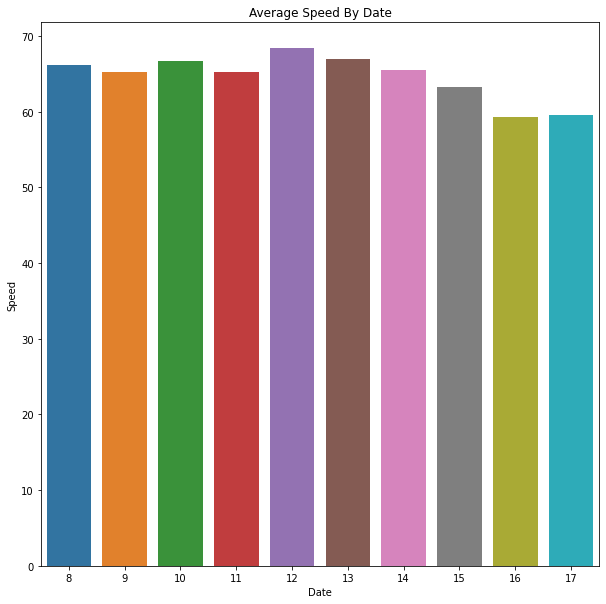

In [7]:
plt.figure(figsize=(10,10))
import seaborn as sns
ax = sns.barplot(x='Day',y='value',data=trafficAverageSpeedByDate)
ax.set(xlabel='Date', ylabel='Speed')
plt.title("Average Speed By Date")
plt.show()

#### By the above graph, we can prove that our assumption of speeds going down after 14th is true.

### Lets now see what's the average speeds by hours in day.

In [8]:
trafficAverageSpeedByHour = trafficSpeedsData.groupby(['Hour'])['value'].mean().reset_index()
trafficAverageSpeedByHour

,Hour,value
0,0,66.000000
1,1,56.200000
2,2,62.500000
3,3,59.000000
4,4,65.500000
5,5,65.875000
6,6,64.440000
7,7,65.452381
8,8,65.387755
9,9,66.639344


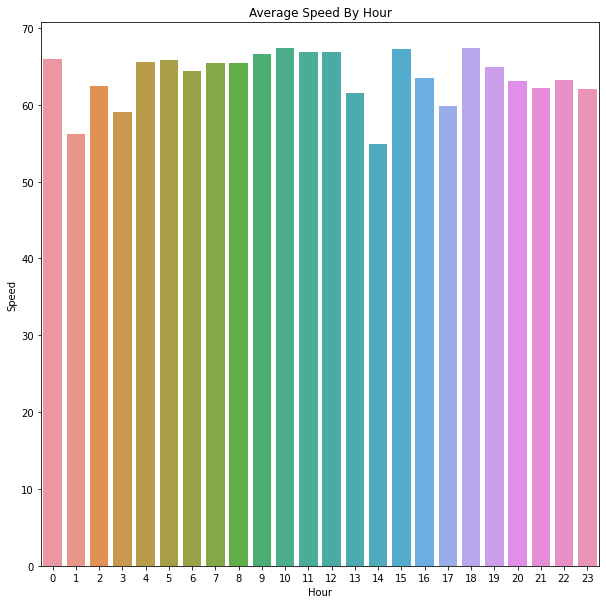

In [9]:
plt.figure(figsize=(10,10))
import seaborn as sns
ax = sns.barplot(x='Hour',y='value',data=trafficAverageSpeedByHour)
ax.set(xlabel='Hour', ylabel='Speed')
plt.title("Average Speed By Hour")
plt.show()

#### Lets now see what's the max speed by hours in day.

In [10]:
trafficMaxSpeedByDay = trafficSpeedsData.groupby(['Day'])['value'].max().reset_index()
trafficMaxSpeedByDay

,Day,value
0,8,76
1,9,79
2,10,76
3,11,81
4,12,80
5,13,76
6,14,75
7,15,90
8,16,74
9,17,73


## Anomaly Detection using One Class SVM

In [11]:
from sklearn.svm import OneClassSVM
from sklearn import preprocessing

# using contaminatation values based on example here .. https://machinelearningmastery.com/one-class-classification-algorithms/ 

model = OneClassSVM(nu=0.95 * 0.05)
data=trafficSpeedsData[['value','Hour','Day']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
model.fit(data)
trafficSpeedsData['anomalySVM'] = pd.Series(model.predict(data))

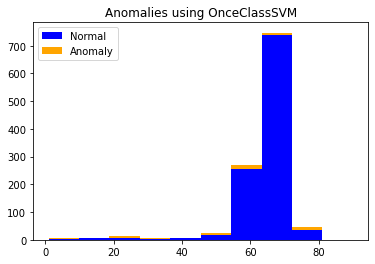

In [12]:
nonanomaly = trafficSpeedsData.loc[trafficSpeedsData['anomalySVM'] == 1, 'value']
anomaly = trafficSpeedsData.loc[trafficSpeedsData['anomalySVM'] == -1, 'value']

fig, axs = plt.subplots()
axs.hist([nonanomaly,anomaly], stacked=True, color=['blue', 'orange'], label=['Normal', 'Anomaly'])
plt.title("Anomalies using OnceClassSVM")
plt.legend()
plt.show()

In [13]:
trafficSpeedsData

,timestamp,value,Hour,Day,anomalySVM
0,2015-09-08 11:39:00,73,11,8,1
1,2015-09-08 11:44:00,62,11,8,-1
2,2015-09-08 11:59:00,66,11,8,1
3,2015-09-08 12:19:00,69,12,8,1
4,2015-09-08 12:24:00,65,12,8,1
...,...,...,...,...,...
1122,2015-09-17 13:45:00,33,13,17,1
1123,2015-09-17 13:50:00,23,13,17,-1
1124,2015-09-17 13:55:00,26,13,17,-1
1125,2015-09-17 14:00:00,19,14,17,1


## Anomaly Detection using Isolation Forest

In [14]:
from sklearn.ensemble import IsolationForest
model = IsolationForest(contamination = 0.05)
data=trafficSpeedsData[['value','Hour','Day']]
min_max_scaler = preprocessing.StandardScaler()
np_scaled = min_max_scaler.fit_transform(data)
model.fit(data)

trafficSpeedsData['forest'] = pd.Series(model.predict(data))

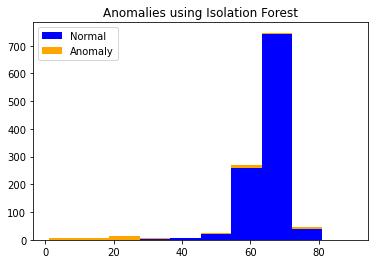

In [15]:
nonanomaly = trafficSpeedsData.loc[trafficSpeedsData['forest'] == 1, 'value']
anomaly = trafficSpeedsData.loc[trafficSpeedsData['forest'] == -1, 'value']

fig, axs = plt.subplots()
axs.hist([nonanomaly,anomaly], stacked=True, color=['blue', 'orange'], label=['Normal', 'Anomaly'])
plt.title("Anomalies using Isolation Forest")
plt.legend()
plt.show()

In [16]:
trafficMeansSpeedByAnomalyForest = trafficSpeedsData.groupby(['forest'])['value'].mean().reset_index()
trafficMeansSpeedByAnomalyForest

,forest,value
0,-1,41.333333
1,1,65.258879


In [17]:
trafficMeansSpeedByAnomalySVM = trafficSpeedsData.groupby(['anomalySVM'])['value'].mean().reset_index()
trafficMeansSpeedByAnomalySVM

,anomalySVM,value
0,-1,54.036364
1,1,64.562500


### Conclusions

By above analysis, We clearly see that, anomalies are identified at lower speeds.For Isolation forest mean speeds for which anomalies are identified are 38 and for One class SvM it is 54
Both the algorithms identified around 65 to be normal speeds, Which can conclude that, the sensors are placed on expressways, where the minimum speed is around 60.